Sentimental analysis for Amazon review: an emperical study on decision making

In [1]:
!pip install transformers tqdm pandas statsmodels datasets scikit-learn flax jax jaxlib linearmodels statsmodels datasets scikit-learn matplotlib

Here loading dataset directly from huggingface

In [3]:
import datasets
from datasets import load_dataset
import pandas as pd

datasets.logging.set_verbosity_error()
data = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)

print(data["full"].column_names)

df = pd.DataFrame(data["full"])

print(df.head())


Generating full split: 0 examples [00:00, ? examples/s]

['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']
   rating                                      title  \
0     5.0  Such a lovely scent but not overpowering.   
1     4.0     Works great but smells a little weird.   
2     5.0                                       Yes!   
3     1.0                          Synthetic feeling   
4     5.0                                         A+   

                                                text images        asin  \
0  This spray is really nice. It smells really go...     []  B00YQ6X8EO   
1  This product does what I need it to do, I just...     []  B081TJ8YS3   
2                          Smells good, feels great!     []  B07PNNCSP9   
3                                     Felt synthetic     []  B09JS339BZ   
4                                            Love it     []  B08BZ63GMJ   

  parent_asin                       user_id      timestamp  helpful_vote  \
0  B00YQ6X8EO 

Feature Engineering (Here I think still have some space of improvement, like how to find(or build) useful features, i.e. word's appear frequency)

In [4]:
df['review_length'] = df['text'].apply(len)
df['helpful_vote'] = df['helpful_vote'].fillna(0)
df['verified_purchase'] = df['verified_purchase'].apply(lambda x: 1 if x else 0)
df['has_images'] = df['images'].apply(lambda x: 1 if x else 0)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday
print(df.head())

   rating                                      title  \
0     5.0  Such a lovely scent but not overpowering.   
1     4.0     Works great but smells a little weird.   
2     5.0                                       Yes!   
3     1.0                          Synthetic feeling   
4     5.0                                         A+   

                                                text images        asin  \
0  This spray is really nice. It smells really go...     []  B00YQ6X8EO   
1  This product does what I need it to do, I just...     []  B081TJ8YS3   
2                          Smells good, feels great!     []  B07PNNCSP9   
3                                     Felt synthetic     []  B09JS339BZ   
4                                            Love it     []  B08BZ63GMJ   

  parent_asin                       user_id               timestamp  \
0  B00YQ6X8EO  AGKHLEW2SOWHNMFQIJGBECAF7INQ 2020-05-05 14:08:48.923   
1  B081TJ8YS3  AGKHLEW2SOWHNMFQIJGBECAF7INQ 2020-05-04 18:10:55.070   

In [5]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

#	Load the DistilBERT pre-trained model and the corresponding tokenizer.
#	Load the model onto the CUDA device (GPU) for inference, which is why I choose to build the project on CoLAB: My laptop chip was M1 Pro which is not support to CUDA, I can only accelerate training through CPU. So for the concern of time cost, I choosed Colab Pro with CUDA support

model_name = "Dmyadav2001/Sentimental-Analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to('cuda')

# The truncate_text function is used to truncate text that exceeds the maximum length, which will help me decrease GPU memory and RAM usage, speed up the training
def truncate_text(text, max_length=512):
    return text[:max_length]
# The preprocess_and_analyze function tokenizes the text, encodes it, and feeds it into the model to compute sentiment scores.
#	The softmax function is used to compute the probability of each sentiment class, and the difference between the positive and negative sentiment scores is calculated.
def preprocess_and_analyze(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt").to('cuda')
    with torch.no_grad():
        logits = model(**inputs).logits
    scores = torch.nn.functional.softmax(logits, dim=-1)
    sentiments = scores[:, 1] - scores[:, 0]  # POSITIVE score - NEGATIVE score
    return sentiments.cpu().numpy()
# The parallel_processing function processes each batch of text data, calls the preprocess_and_analyze function for analysis, and returns the sentiment scores. Same purpose of Truncation, it allows me to mapping function to processing data by 20 units per batch.
def parallel_processing(batch_texts):
    batch_predictions = preprocess_and_analyze(batch_texts)
    return np.array(batch_predictions)

batch_size = 20
all_predictions = []

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for i in range(0, len(df), batch_size):
        batch_texts = df['text'][i:i+batch_size].tolist()
        futures.append(executor.submit(parallel_processing, batch_texts))

    for future in tqdm(futures, desc="Processing batches"):
        all_predictions.extend(future.result())

df['sentiment_score'] = all_predictions
df.to_csv('sentiment_analysis_results.csv', index=False)
df.to_json('sentiment_analysis_results.jsonl', orient='records', lines=True)
print(df.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing batches: 100%|██████████| 35077/35077 [32:26<00:00, 18.02it/s]


   rating                                      title  \
0     5.0  Such a lovely scent but not overpowering.   
1     4.0     Works great but smells a little weird.   
2     5.0                                       Yes!   
3     1.0                          Synthetic feeling   
4     5.0                                         A+   

                                                text images        asin  \
0  This spray is really nice. It smells really go...     []  B00YQ6X8EO   
1  This product does what I need it to do, I just...     []  B081TJ8YS3   
2                          Smells good, feels great!     []  B07PNNCSP9   
3                                     Felt synthetic     []  B09JS339BZ   
4                                            Love it     []  B08BZ63GMJ   

  parent_asin                       user_id               timestamp  \
0  B00YQ6X8EO  AGKHLEW2SOWHNMFQIJGBECAF7INQ 2020-05-05 14:08:48.923   
1  B081TJ8YS3  AGKHLEW2SOWHNMFQIJGBECAF7INQ 2020-05-04 18:10:55.070   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.8058
              precision    recall  f1-score   support

           0       0.83      0.76      0.79     46070
           1       0.37      0.02      0.05     18051
           2       0.75      0.95      0.84     76185

    accuracy                           0.77    140306
   macro avg       0.65      0.58      0.56    140306
weighted avg       0.73      0.77      0.72    140306

[[35088   305 10677]
 [ 4247   436 13368]
 [ 3125   452 72608]]


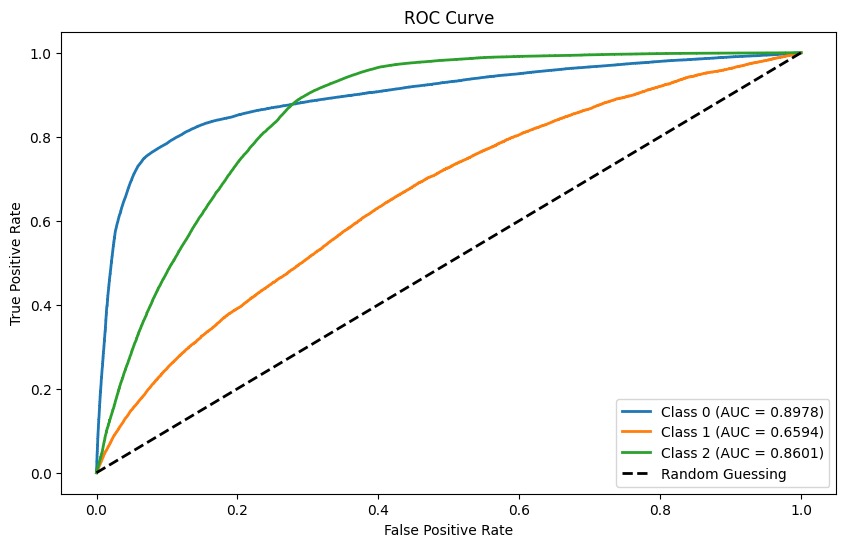

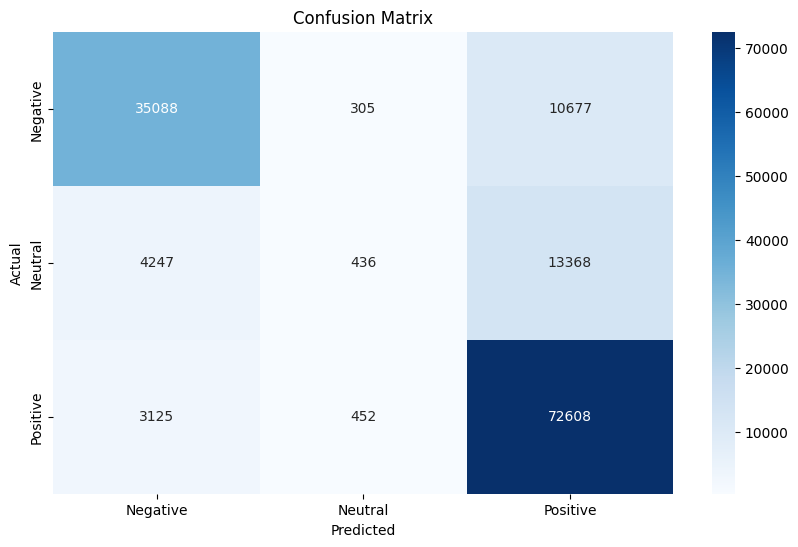

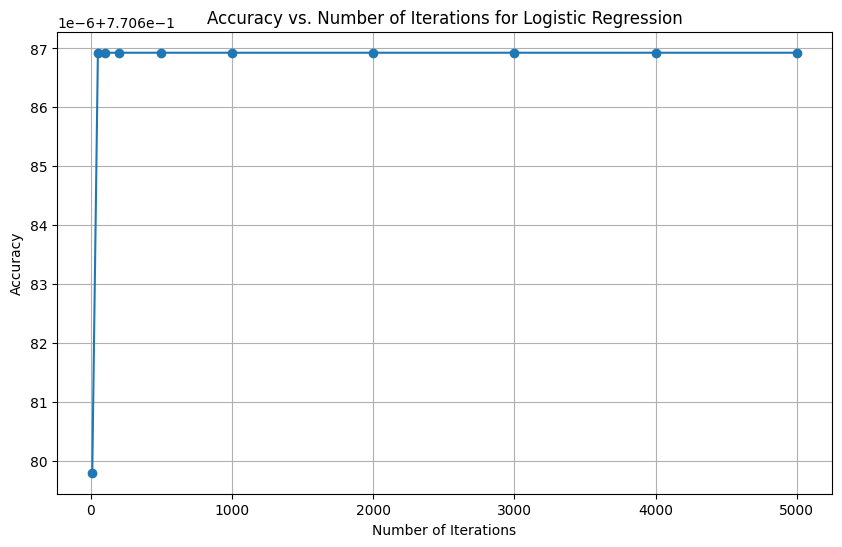

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json

jsonl_file_path = '/content/sentiment_analysis_results.jsonl'

with open(jsonl_file_path, 'r') as f:
    jsonl_data = [json.loads(line) for line in f]

df = pd.DataFrame(jsonl_data)

# Assuming df is already loaded and preprocessed
# Convert sentiment scores to three classes: negative, neutral, positive
def categorize_sentiment(score):
    if score > 0.35:  # Threshold for positive sentiment
        return 2
    elif score < -0.35:  # Threshold for negative sentiment
        return 0
    else:
        return 1  # Neutral sentiment

df['sentiment_label'] = df['sentiment_score'].apply(categorize_sentiment)

# Prepare feature and target data
X = df[['rating', 'review_length', 'helpful_vote', 'verified_purchase', 'has_images', 'year', 'month', 'day', 'weekday']]
y = df['sentiment_label']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of different iteration numbers to evaluate
iterations = [10, 50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000]
accuracies = []

# Train and evaluate the logistic regression model for different iteration numbers
for iter_num in iterations:
    log_reg = LogisticRegression(max_iter=iter_num, multi_class='multinomial', solver='lbfgs')
    log_reg.fit(X_train, y_train)

    # Predict on the test set
    y_pred = log_reg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Save detailed evaluation results for the highest number of iterations
    if iter_num == max(iterations):
        y_pred_proba = log_reg.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        print(f"AUC: {auc:.4f}")
        print(classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        print(cm)

        # Plot ROC curve for each class
        plt.figure(figsize=(10, 6))
        for i in range(3):  # We have three classes now
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
            plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc_score(y_test == i, y_pred_proba[:, i]):.4f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

        # Plot confusion matrix
        plt.figure(figsize=(10, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

# Visualize the relationship between number of iterations and accuracy
plt.figure(figsize=(10, 6))
plt.plot(iterations, accuracies, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Iterations for Logistic Regression')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.7381
              precision    recall  f1-score   support

           0       0.60      0.57      0.58     41870
           1       0.52      0.22      0.31     39088
           2       0.60      0.86      0.71     59348

    accuracy                           0.59    140306
   macro avg       0.58      0.55      0.53    140306
weighted avg       0.58      0.59      0.56    140306

[[23724  3860 14286]
 [11413  8492 19183]
 [ 4361  3832 51155]]


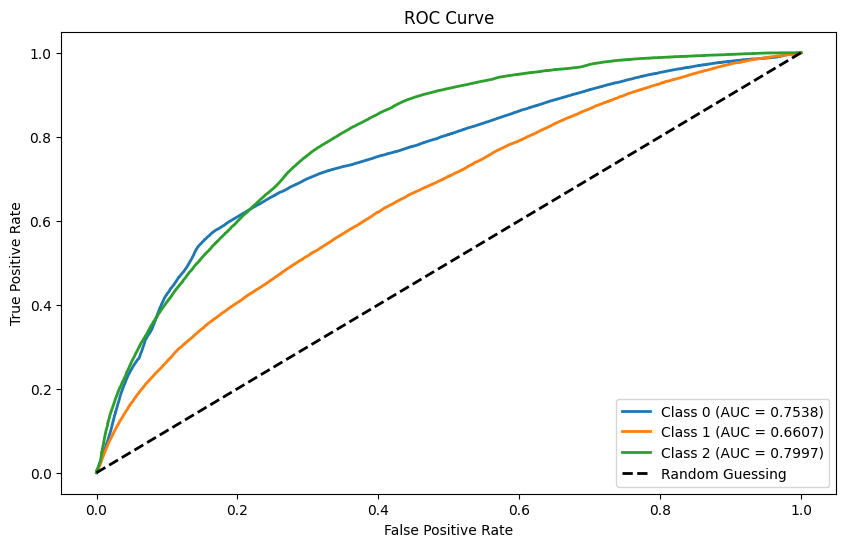

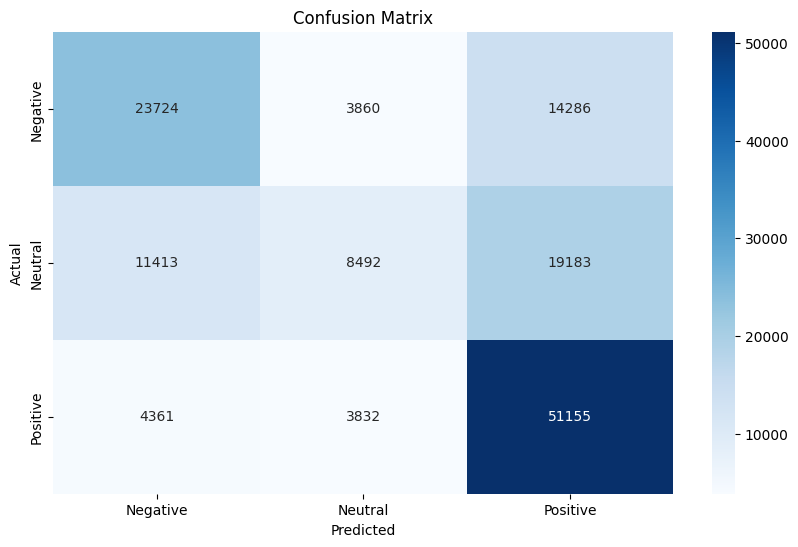

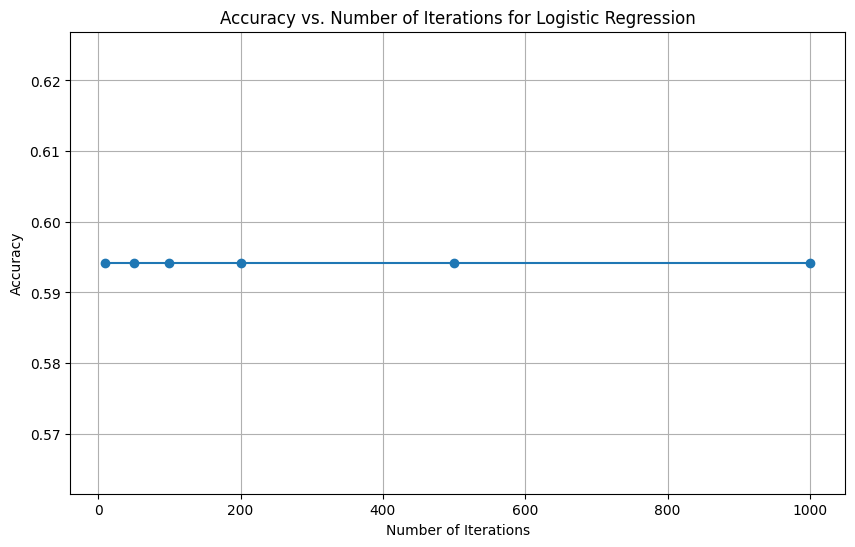

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json

jsonl_file_path = '/content/drive/MyDrive/TER/Code/Training Result/sentiment_analysis_results_RoBERTa.jsonl'

with open(jsonl_file_path, 'r') as f:
    jsonl_data = [json.loads(line) for line in f]

df = pd.DataFrame(jsonl_data)

# Assuming df is already loaded and preprocessed
# Convert sentiment scores to three classes: negative, neutral, positive
def categorize_sentiment(score):
    if score > 0.35:  # Threshold for positive sentiment
        return 2
    elif score < -0.35:  # Threshold for negative sentiment
        return 0
    else:
        return 1  # Neutral sentiment

df['sentiment_label'] = df['sentiment_score_roberta'].apply(categorize_sentiment)

# Prepare feature and target data
X = df[['rating', 'review_length', 'helpful_vote', 'verified_purchase', 'has_images', 'year', 'month', 'day', 'weekday']]
y = df['sentiment_label']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of different iteration numbers to evaluate
iterations = [10, 50, 100, 200, 500, 1000]
accuracies = []

# Train and evaluate the logistic regression model for different iteration numbers
for iter_num in iterations:
    log_reg = LogisticRegression(max_iter=iter_num, multi_class='multinomial', solver='lbfgs')
    log_reg.fit(X_train, y_train)

    # Predict on the test set
    y_pred = log_reg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Save detailed evaluation results for the highest number of iterations
    if iter_num == max(iterations):
        y_pred_proba = log_reg.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        print(f"AUC: {auc:.4f}")
        print(classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        print(cm)

        # Plot ROC curve for each class
        plt.figure(figsize=(10, 6))
        for i in range(3):  # We have three classes now
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
            plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc_score(y_test == i, y_pred_proba[:, i]):.4f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

        # Plot confusion matrix
        plt.figure(figsize=(10, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

# Visualize the relationship between number of iterations and accuracy
plt.figure(figsize=(10, 6))
plt.plot(iterations, accuracies, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Iterations for Logistic Regression')
plt.grid(True)
plt.show()

<ipython-input-9-185e90c2dd21>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_review_length'] = np.log(X['review_length'] + 1)
<ipython-input-9-185e90c2dd21>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['rating_review_length'] = X['rating'] * X['review_length']


AUC: 0.8880
              precision    recall  f1-score   support

           0       0.89      0.69      0.78     54242
           1       0.83      0.94      0.88     86064

    accuracy                           0.85    140306
   macro avg       0.86      0.82      0.83    140306
weighted avg       0.85      0.85      0.84    140306

[[37649 16593]
 [ 4774 81290]]


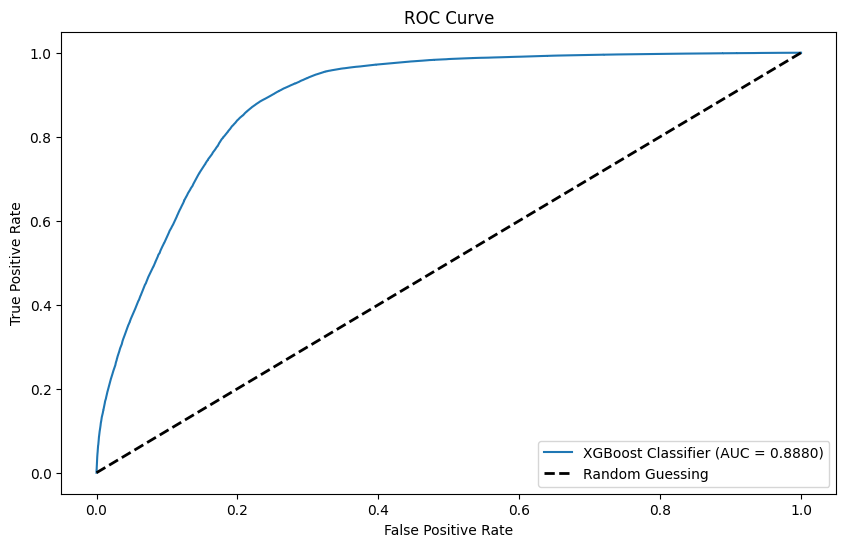

<Figure size 1000x600 with 0 Axes>

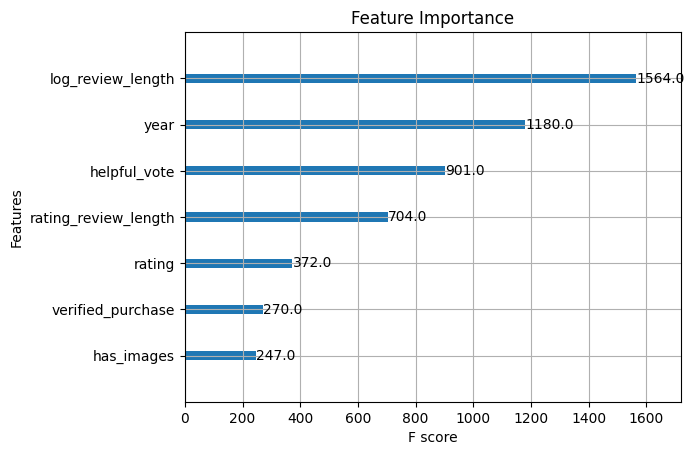

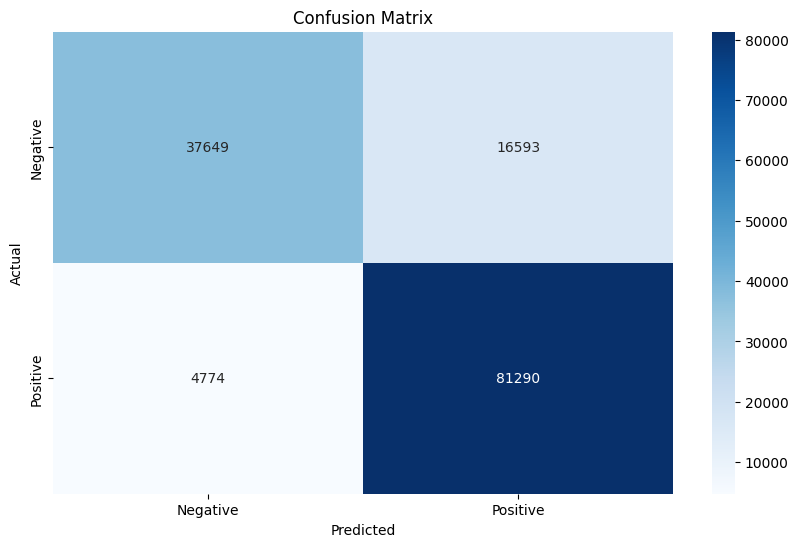

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df['sentiment_label'] = np.where(df['sentiment_score'] > 0, 1, 0)

X = df[['rating', 'review_length', 'helpful_vote', 'verified_purchase', 'has_images', 'year']]
y = df['sentiment_label']

X['log_review_length'] = np.log(X['review_length'] + 1)
X['rating_review_length'] = X['rating'] * X['review_length']

X = X.drop(columns=['review_length'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100)
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'XGBoost Classifier (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 6))
plot_importance(xgb_clf, max_num_features=10)
plt.title('Feature Importance')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
!pip install

In [ ]:
from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
import statsmodels.api as sm
import json
file_path = '/content/sentiment_analysis_results.jsonl'
data = []

with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))
df = pd.DataFrame(data)

print(df.columns)

df = df.set_index(['user_id', 'timestamp'])

X = df[['rating', 'review_length', 'helpful_vote', 'verified_purchase', 'has_images', 'year']]
y = df['sentiment_score']

X = sm.add_constant(X)

fixed_effects_model = PanelOLS(y, X, entity_effects=True)
fixed_effects_results = fixed_effects_model.fit()

print(fixed_effects_results)

random_effects_model = RandomEffects(y, X)
random_effects_results = random_effects_model.fit()

print(random_effects_results)

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'review_length',
       'has_images', 'year', 'month', 'day', 'weekday', 'sentiment_score'],
      dtype='object')
                          PanelOLS Estimation Summary                           
Dep. Variable:        sentiment_score   R-squared:                        0.4197
Estimator:                   PanelOLS   R-squared (Between):              0.5312
No. Observations:              701528   R-squared (Within):               0.4197
Date:                Tue, Jun 11 2024   R-squared (Overall):              0.5244
Time:                        16:13:36   Log-likelihood                 1.916e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      5587.0
Entities:                      631986   P-value                           0.0000
Avg Obs:             

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects
from sklearn.preprocessing import StandardScaler
import json
file_path = '/content/sentiment_analysis_results.jsonl'
data = []

with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))
df = pd.DataFrame(data)

df['log_review_length'] = np.log(df['review_length'] + 1)
df['rating_review_length'] = df['rating'] * df['review_length']

scaler = StandardScaler()
df[['rating', 'log_review_length', 'helpful_vote', 'verified_purchase', 'has_images',
    'year', 'month', 'day', 'weekday', 'rating_review_length']] = scaler.fit_transform(
    df[['rating', 'log_review_length', 'helpful_vote', 'verified_purchase', 'has_images',
        'year', 'month', 'day', 'weekday', 'rating_review_length']])

df = df.set_index(['user_id', 'timestamp'])

X = df[['rating', 'log_review_length', 'helpful_vote', 'verified_purchase', 'has_images',
        'year', 'month', 'day', 'weekday', 'rating_review_length']]
y = df['sentiment_score']

X = sm.add_constant(X)

fixed_effects_model = PanelOLS(y, X, entity_effects=True)
fixed_effects_results = fixed_effects_model.fit()
print("Fixed Effects Model Results:")
print(fixed_effects_results)

random_effects_model = RandomEffects(y, X)
random_effects_results = random_effects_model.fit()
print("Random Effects Model Results:")
print(random_effects_results)

gls_model = sm.GLS(y, X)
gls_results = gls_model.fit()
print("GLS Model Results:")
print(gls_results.summary())

Fixed Effects Model Results:
                          PanelOLS Estimation Summary                           
Dep. Variable:        sentiment_score   R-squared:                        0.4251
Estimator:                   PanelOLS   R-squared (Between):              0.5331
No. Observations:              701528   R-squared (Within):               0.4251
Date:                Tue, Jun 11 2024   R-squared (Overall):              0.5261
Time:                        16:31:05   Log-likelihood                 1.949e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      5141.4
Entities:                      631986   P-value                           0.0000
Avg Obs:                       1.1100   Distribution:                F(10,69532)
Min Obs:                       1.0000                                           
Max Obs:                       165.00   F-statistic (robust):             5141.4

<ipython-input-53-da2a190a5a4a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'log_review_length'] = np.log(X['review_length'] + 1)
<ipython-input-53-da2a190a5a4a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'rating_review_length'] = X['rating'] * X['review_length']


AUC: 0.8842
              precision    recall  f1-score   support

           0       0.86      0.71      0.78     48326
           1       0.86      0.94      0.90     91980

    accuracy                           0.86    140306
   macro avg       0.86      0.83      0.84    140306
weighted avg       0.86      0.86      0.86    140306

[[34366 13960]
 [ 5474 86506]]
Optimization terminated successfully.
         Current function value: 0.373446
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        sentiment_label   No. Observations:               561222
Model:                          Logit   Df Residuals:                   561211
Method:                           MLE   Df Model:                           10
Date:                Tue, 11 Jun 2024   Pseudo R-squ.:                  0.4202
Time:                        17:20:57   Log-Likelihood:            -2.0959e+05
converged:                       True   LL-Null:      

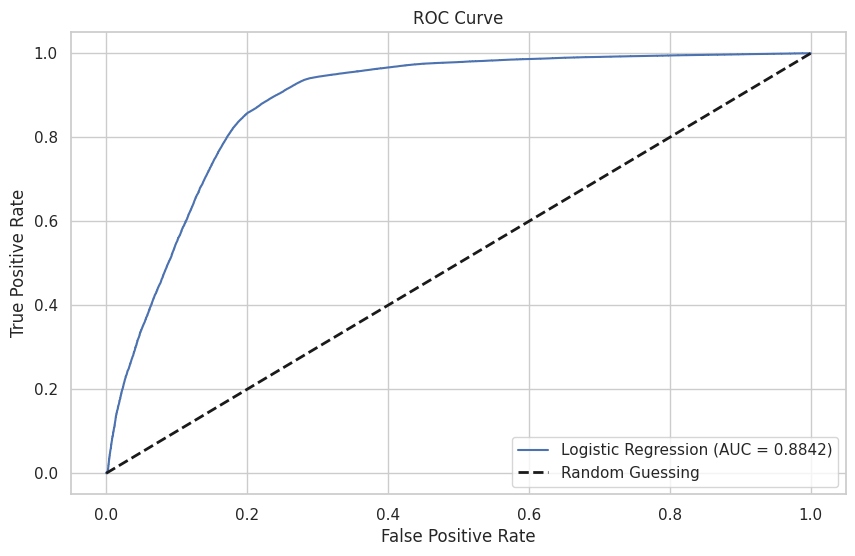

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import statsmodels.api as sm

df['sentiment_label'] = np.where(df['sentiment_score'] > 0, 1, 0)

X = df[['rating', 'review_length', 'helpful_vote', 'verified_purchase', 'has_images', 'year', 'month', 'day', 'weekday']]
y = df['sentiment_label']

X.loc[:, 'log_review_length'] = np.log(X['review_length'] + 1)
X.loc[:, 'rating_review_length'] = X['rating'] * X['review_length']

X = X.drop(columns=['review_length'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

X_train_sm = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_sm)
logit_results = logit_model.fit()
print(logit_results.summary())

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

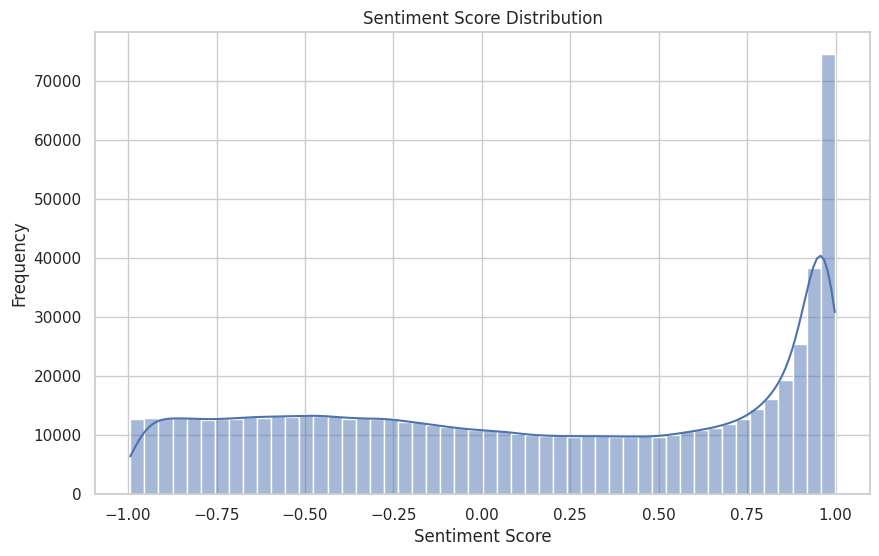

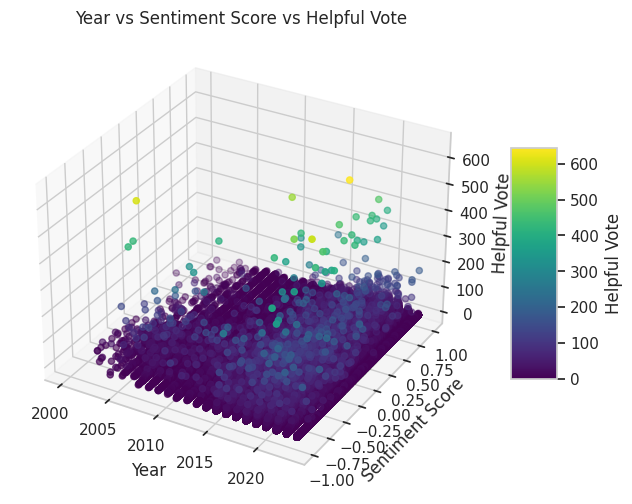

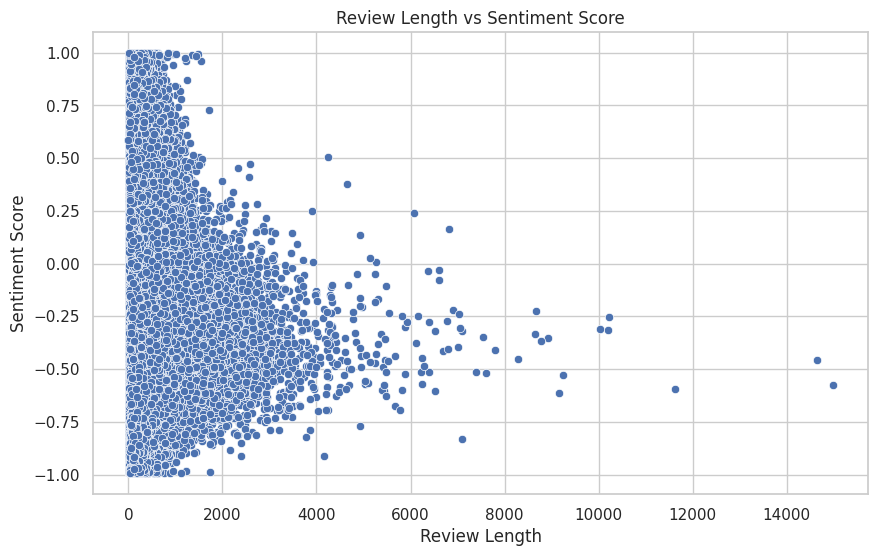

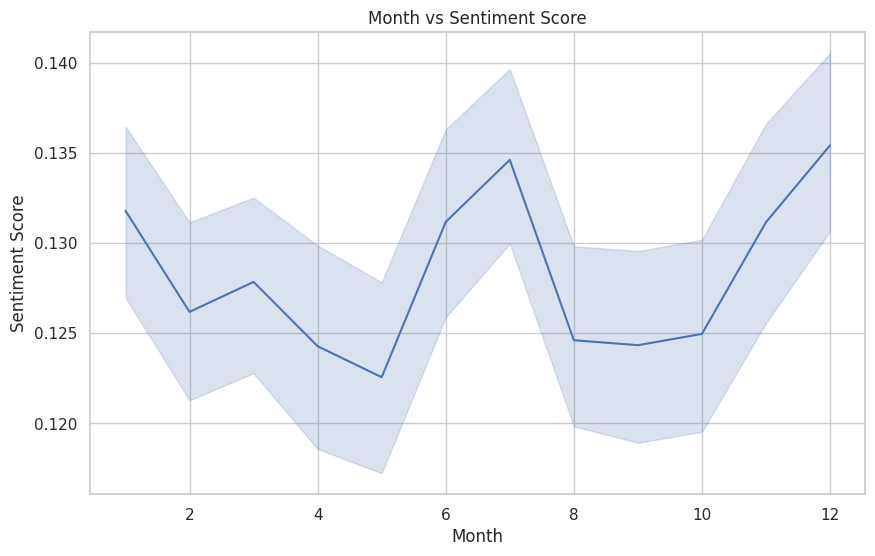

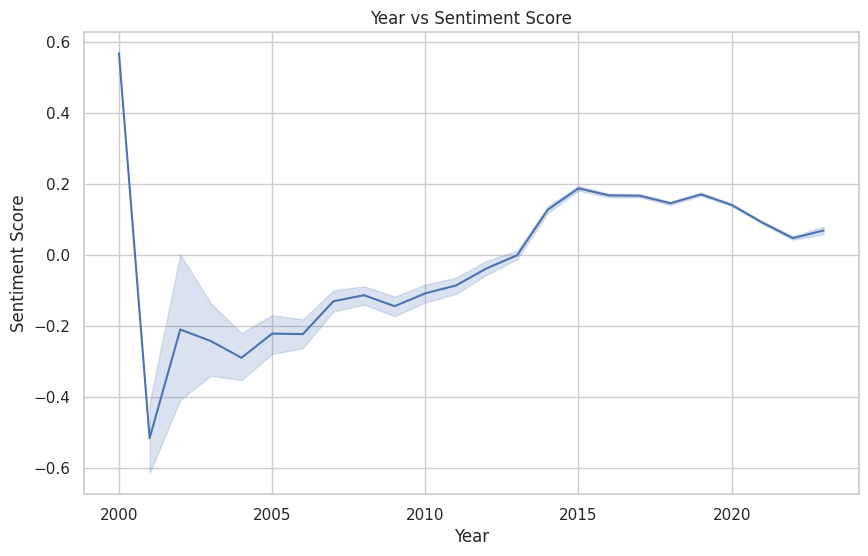

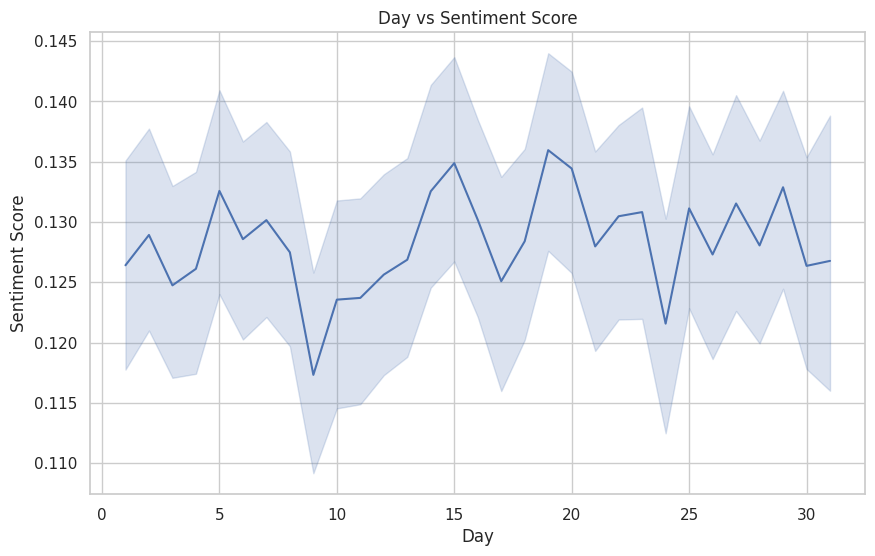

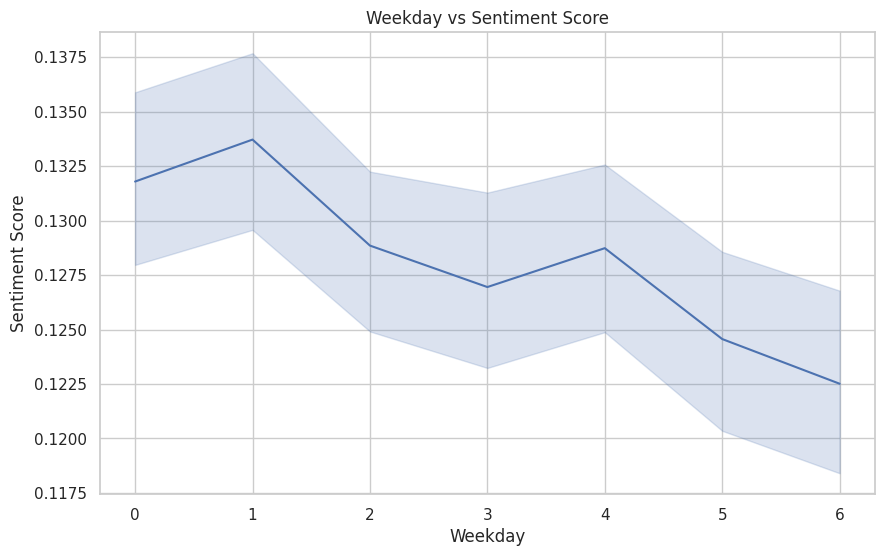

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
from mpl_toolkits.mplot3d import Axes3D
# roberta
jsonl_file_path = '/content/drive/MyDrive/TER/Code/Training Result/sentiment_analysis_results_RoBERTa.jsonl'

with open(jsonl_file_path, 'r') as f:
    jsonl_data = [json.loads(line) for line in f]

df = pd.DataFrame(jsonl_data)
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment_score_roberta'], bins=50, kde=True)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot data
x = df['year']
y = df['sentiment_score_roberta']
z = df['helpful_vote']

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=z, cmap='viridis')

# Add labels and title
ax.set_title('Year vs Sentiment Score vs Helpful Vote')
ax.set_xlabel('Year')
ax.set_ylabel('Sentiment Score')
ax.set_zlabel('Helpful Vote')

# Add a color bar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Helpful Vote')

plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_length', y='sentiment_score_roberta', data=df)
plt.title('Review Length vs Sentiment Score')
plt.xlabel('Review Length')
plt.ylabel('Sentiment Score')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='sentiment_score_roberta', data=df)
plt.title('Month vs Sentiment Score')
plt.xlabel('Month')
plt.ylabel('Sentiment Score')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='sentiment_score_roberta', data=df)
plt.title('Year vs Sentiment Score')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='day', y='sentiment_score_roberta', data=df)
plt.title('Day vs Sentiment Score')
plt.xlabel('Day')
plt.ylabel('Sentiment Score')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='weekday', y='sentiment_score_roberta', data=df)
plt.title('Weekday vs Sentiment Score')
plt.xlabel('Weekday')
plt.ylabel('Sentiment Score')
plt.show()



In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from tqdm import tqdm

model_name = "Eugenia/roberta-base-bne-finetuned-amazon_reviews_multi"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to('cuda')

def preprocess_and_analyze_roberta(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt").to('cuda')
    with torch.no_grad():
        logits = model(**inputs).logits
    scores = torch.nn.functional.softmax(logits, dim=-1)
    sentiments = scores[:, 1] - scores[:, 0]  # Positive score - Negative score
    return sentiments.cpu().numpy()

batch_size = 20
all_predictions_roberta = []

for i in tqdm(range(0, len(df), batch_size)):
    batch_texts = df['text'][i:i+batch_size].tolist()
    batch_predictions = preprocess_and_analyze_roberta(batch_texts)
    all_predictions_roberta.extend(batch_predictions)

df['sentiment_score_roberta'] = all_predictions_roberta

df.to_csv('sentiment_analysis_results_RoBERTa.csv', index=False)
df.to_json('sentiment_analysis_results_RoBERTa.jsonl', orient='records', lines=True)

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

all_predictions_vader = [analyze_sentiment_vader(text) for text in tqdm(df['text'])]

df['sentiment_score_vader'] = all_predictions_vader

df['sentiment_label_vader'] = np.where(df['sentiment_score_vader'] > 0, 1, 0)

X = df[['rating', 'review_length', 'helpful_vote', 'verified_purchase', 'has_images', 'year', 'month', 'day', 'weekday']]
y = df['sentiment_label_vader']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg_vader = LogisticRegression(max_iter=1000)
log_reg_vader.fit(X_train, y_train)

y_pred_vader = log_reg_vader.predict(X_test)
y_pred_proba_vader = log_reg_vader.predict_proba(X_test)[:, 1]
auc_vader = roc_auc_score(y_test, y_pred_proba_vader)
print(f"VADER + Logistic Regression AUC: {auc_vader:.4f}")
print(classification_report(y_test, y_pred_vader))
print(confusion_matrix(y_test, y_pred_vader))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
plt.figure(figsize=(10, 6))

fpr_roberta, tpr_roberta, _ = roc_curve(df['sentiment_label'], df['sentiment_score_roberta'])
plt.plot(fpr_roberta, tpr_roberta, label=f'Roberta (AUC = {roc_auc_score(df["sentiment_label"], df["sentiment_score_roberta"]):.4f})')

fpr_vader, tpr_vader, _ = roc_curve(y_test, y_pred_proba_vader)
plt.plot(fpr_vader, tpr_vader, label=f'VADER + Logistic Regression (AUC = {auc_vader:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

In [ ]:
cm_roberta = confusion_matrix(df['sentiment_label'], np.where(df['sentiment_score_roberta'] > 0, 1, 0))
plt.figure(figsize=(10, 6))
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Roberta')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg), annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Pred